In [155]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.flatten_util import ravel_pytree
from jax.experimental import optimizers

import itertools
from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

In [156]:
class MLP():
  def __init__(self, X, y, layers, init_method = 'glorot', rng_key = random.PRNGKey(0)):
    # Normalize data
    self.Xmean, self.Xstd = X.mean(0), X.std(0)
    self.Ymean, self.Ystd = y.mean(0), y.std(0)
    X = (X - self.Xmean)/self.Xstd
    y = (y - self.Ymean)/self.Ystd

    # Store the normalized trainind data
    self.X = X
    self.y = y
    self.layers = layers

    # Use stax to set up network initialization and evaluation functions
    self.net_init, self.net_apply = self.init_MLP(init_method)
    
    # Initialize parameters, not committing to a batch shape
    self.net_params = self.net_init(rng_key, layers)
                
    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.sgd(1e-4)
    self.opt_state = self.opt_init(self.net_params)

    # Logger to monitor the loss function
    self.loss_log = []
    self.itercount = itertools.count()

  def init_MLP(self, method = 'glorot'):
    # Define init function
    def _init(rng_key, layers):
        # Define methods for initializing the weights
        if method == 'glorot':
          def init_W(rng_key, size):
            in_dim = size[0]
            out_dim = size[1]
            glorot_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return glorot_stddev*random.normal(rng_key, (in_dim, out_dim))
        elif method == 'random':
          def init_W(rng_key, size):
            in_dim = size[0]
            out_dim = size[1]
            return random.uniform(rng_key, (in_dim, out_dim))
        # Perform initialization
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            rng_key, _ = random.split(rng_key)
            W = init_W(rng_key, size=[layers[l], layers[l+1]])
            b = np.zeros((1,layers[l+1]))
            weights.append(W)
            biases.append(b)  
        params = weights, biases
        return params
    # Define apply function
    def _apply(params, input):
        H = input
        weights, biases = params
        num_layers = len(self.layers)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = np.tanh(np.add(np.dot(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = np.add(np.dot(H, W), b)
        return H.flatten()
    return _init, _apply

  def per_example_loglikelihood(self, params, batch):
    X, y = batch
    y_pred = self.net_apply(params, X)
    loss = (y - y_pred)**2
    return loss

  def loss(self, params, batch):
    # Implementation #1
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    loss = np.sum(vmap(pe_loss)(batch))
    return loss

  # Define a compiled update step
  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, batch):
      params = self.get_params(opt_state)
      g = grad(self.loss)(params, batch)
      return self.opt_update(i, g, opt_state)

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx, :], self.y[batch_idx]

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
      self.net_params = self.get_params(self.opt_state)
      loss_value = self.loss(self.net_params, batch)
      self.loss_log.append(loss_value)
      pbar.set_postfix({'Loss': loss_value})

  def predict(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    pred_fn = lambda x: self.net_apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    y_pred = y_pred*self.Ystd + self.Ymean
    return y_pred

  def compute_activations(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    def MLP_pass(params, input):
      H = input
      H_list = []
      H_list.append(H)
      weights, biases = params
      num_layers = len(self.layers)
      for l in range(0,num_layers-2):
          W = weights[l]
          b = biases[l]
          H = np.tanh(np.add(np.dot(H, W), b))
          H_list.append(H)
      W = weights[-1]
      b = biases[-1]
      H = np.add(np.dot(H, W), b)
      H_list.append(H)
      return H_list
    # Get predictions
    pred_fn = lambda x: MLP_pass(params, x)
    H_list = vmap(pred_fn)(X_star)
    return H_list

In [157]:
def f(x):
  x1, x2 = x[0], x[1]
  y = np.sqrt(x1**2 + x2**2)
  return y

In [158]:
rng_key = random.PRNGKey(0)

d = 2
lb = -2.0*np.ones(d)
ub = 2.0*np.ones(d)
n = 2000
noise = 0.1

# Create training data
X = lb + (ub-lb)*random.uniform(rng_key, (n, d))
y = vmap(f)(X)
y = y + noise*y.std(0)*random.normal(rng_key, y.shape)

# Create test data
nn = 50
xx = np.linspace(lb[0], ub[0], nn)
yy = np.linspace(lb[1], ub[1], nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

In [159]:
layers = [2, 32, 32, 32, 32, 1]
init_method = 'random'
model = MLP(X, y, layers, init_method, rng_key)

In [160]:
model.train(num_epochs = 2000, batch_size = 128)

100%|██████████| 2000/2000 [04:29<00:00,  7.43it/s, Loss=72.282684]


In [161]:
opt_params = model.net_params
y_pred = model.predict(opt_params, X_star)

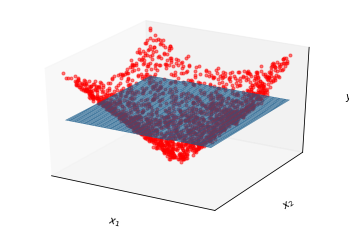

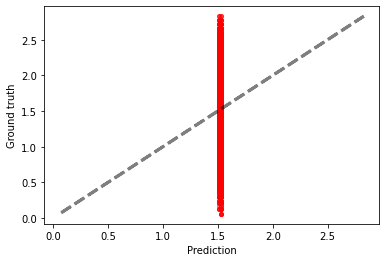

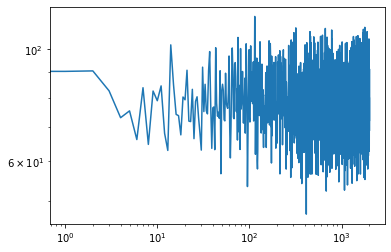

In [162]:
Yplot = griddata(X_star, y_pred.flatten(), (XX, YY), method='cubic')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], y, 'r.', ms = 6, alpha = 0.5)
ax.plot_surface(XX, YY, Yplot, alpha = 0.8)
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')

plt.figure()
plt.plot(y_pred, y_star, 'r.', ms = 8, alpha = 0.5)
plt.plot(y_star, y_star, 'k--', lw = 3, alpha = 0.5)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')

plt.figure()
plt.plot(model.loss_log)
plt.yscale('log')
plt.xscale('log')

In [165]:
full_batch = model.X, model.y
activations = model.compute_activations(opt_params, X_star)
weight_grads, bias_grads = grad(model.loss)(opt_params, full_batch)

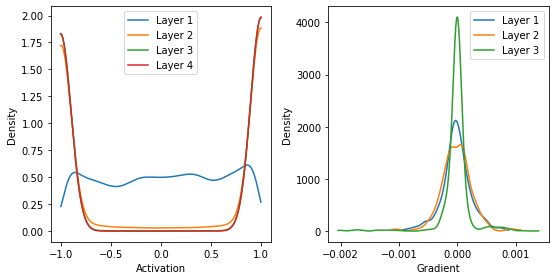

In [166]:
from scipy.stats import kde

def kde1d(x):
  nn = 1000
  xi = np.linspace(x.min(), x.max(), nn)
  k = kde.gaussian_kde(x)
  zi = k(xi)
  return xi,zi

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
for i in range(1,len(activations)-1):
  x, z = kde1d(activations[i].flatten())
  plt.plot(x, z, label = 'Layer %d' % (i))
plt.legend()
plt.xlabel('Activation')
plt.ylabel('Density')
plt.tight_layout()
plt.subplot(1,2,2)
for i in range(1,len(weight_grads)-1):
  x, z = kde1d(weight_grads[i].flatten())
  plt.plot(x, z, label = 'Layer %d' % (i))
plt.legend()
plt.xlabel('Gradient')
plt.ylabel('Density')
plt.tight_layout()
